# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- Anomalies detection
- LSM
- Kalman filter (matrix, 1 order)

## Imports

In [1126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [1127]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Parameters

In [1128]:
PARAM_selection_size = 100
PARAM_anomaly_size = int(0.1 * PARAM_selection_size)
PARAM_widnow_size = int(0.2 * PARAM_selection_size)

PARAM_normal_mean = 0
PARAM_normal_std = 3

PARAM_max_test_pow = 11

PARAM_alpha = 0.2
PARAM_beta = 0.2

## Functions

In [1129]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # remove trend from other data
    trend_data = df[trend_column].copy()
    for column in df.columns:
            df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [1130]:
def lsm_create_f(size, pol_pow):
    """
    Creating F matrix:
    1, x, x^2, ..., x^PARAM_max_pow
    """
    
    F = np.ones((size, pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # pow
        F[:, i] = np.power(np.arange(0, size), i)
    return F


def lsm_coef(y, F):
    """
    Returns matrix of coef. C.
    """

    # 1-d array to row vector
    Y = y.reshape(-1, 1)
    # calc
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    # return coef
    return np.dot(FFIFT, Y)


def lsm(y, pol_pow):
    """
    LSM
    y - 1d array of values,
    pol_pow - polynomial power of model
    """

    F = lsm_create_f(len(y), pol_pow)
    C = lsm_coef(y, F)
    # returning array, reshaped from row vector to 1d
    return np.dot(F, C).reshape(-1)

In [1131]:
def find_anomalies(data, sliding_window_size, lsm_pow, std3):
    """
    Returns indexes of anomalies.
    """
    anomaly_index = []
    
    for i in range(0, len(data) - sliding_window_size):
        # new window
        window = data[i:(sliding_window_size + i)]
        # finding C matrix for current window
        coef = lsm_coef(window, lsm_create_f(sliding_window_size, lsm_pow))
        # prediction of next value
        y_hat = np.dot(lsm_create_f(sliding_window_size + 1, lsm_pow), coef).reshape(-1)[-1]
        # if difference between predicted and real value is more than 3*std => anomaly
        if abs(data[sliding_window_size + i] - y_hat) > std3:
            anomaly_index.append(sliding_window_size + i)
    return anomaly_index

In [1132]:
def fix_anomalies(data, anomaly_index):
    # copy
    data_fix = data.copy()
    # for every anomaly in data
    for i in anomaly_index:
        vals = []
        # append prev value
        vals.append(data_fix[i-1])
        # append value-anomaly
        vals.append(data_fix[i])
        # append next values (presuming they are also value-anomalies) until normal value is found
        ends_with_normal_value = False
        for j in range(i + 1, len(data_fix)):
            vals.append(data_fix[j])
            if j not in anomaly_index:
                ends_with_normal_value = True
                break
        # if ends with normal value - fit a line and restore values
        if ends_with_normal_value:
            step = (vals[-1] - vals[0]) / (len(vals) - 1)
        # else fit a line through 2 previous normal values
        else:
            step = data_fix[i-1] - data_fix[i-2]

        # restore values
        # but if vals ends with normal value - cast True to 1 and dont update the last value, that is normal
        # else casting False to int will result in 0, and the last value, that is also anomal will be updated
        for j in range(len(vals) - 1 - int(ends_with_normal_value)):
            data_fix[i+j] = vals[0] + step * (j + 1)
    return data_fix

In [1133]:
def alpha_beta(data, init_x=0, init_x_der=0.1, alpha=0.1, beta=0.1, t=1):
    # history
    history = {"prediction":[], "measurment":[], "estimation":[]}
    # initial conditions
    x = init_x
    x_der = init_x_der
    # time step
    for i in range(0, len(data), t):
        # prediction
        x_pred = x + (t * x_der)
        x_der_pred = x_der
        # updating current estimation
        x = x_pred + alpha * (data[i] - x_pred)
        x_der = x_der_pred + beta * ((data[i] - x_pred) / t)
        # history
        history["prediction"].append(x_pred)
        history["measurment"].append(data[i])
        history["estimation"].append(x)
    return history


In [1134]:
def mse(data1, data2):
    return (np.square(data1 - data2)).mean()

## Errors and anomalies

In [1135]:
# normal error
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
# starting from PARAM_widnows_size to get std of normal error without anomalies
# (instead of manually removing anomalies from first window)
_normal_anomalies = _normal.copy()
_anomaly_index = np.unique(np.random.randint(PARAM_widnow_size, PARAM_selection_size, PARAM_anomaly_size))
for i in _anomaly_index:
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
        _normal_anomalies[i] *= 2

## Artificial anomalies: last value and two consecutive values to test anomaly detection/restoration algorithms
_anomaly_test_index = [-1, int((PARAM_widnow_size*1.6)), int((PARAM_widnow_size*1.6) + 1)]
for i in _anomaly_test_index:
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
            _normal_anomalies[i] *= 2
print("Indexes of anomalies:", _anomaly_index, "\n")
print("Indexes of test anomalies", _anomaly_test_index)

Indexes of anomalies: [36 52 57 64 65 66 76 91 93] 

Indexes of test anomalies [-1, 32, 33]


## Data

In [1136]:
data = {}

# quadratic, + noise, + anomalies
data["quadratic"] = np.square(np.linspace(0, 10, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomalies

describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies
count,100.000,100.000,100.000
mean,0.000,0.328,0.090
std,0.000,3.000,4.973
min,0.000,-7.460,-14.291
25%,0.000,-1.637,-2.002
50%,0.000,0.365,0.454
75%,0.000,2.393,2.652
max,0.000,7.894,11.317
var,0.000,9.000,24.729


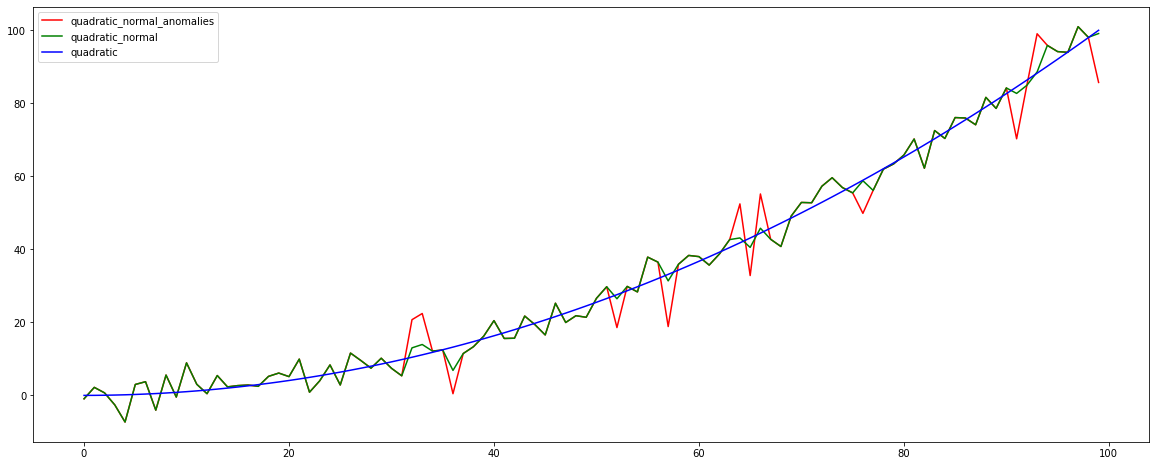

In [1137]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="red")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.legend()
plt.show()

## Detecting Anomalies with Sliding Window

In [1138]:
window = data["quadratic_normal_anomalies"][:PARAM_widnow_size]

std3 = 3 * abs((window - lsm(window, PARAM_best_pow)).std())
print("Estimated 3*std:", std3)

Estimated 3*std: 9.532096822145604


In [1139]:
# save indexes and values of anomalies
anomaly_index = find_anomalies(data["quadratic_normal_anomalies"], PARAM_widnow_size, 1, std3)
anomaly_value = data["quadratic_normal_anomalies"][anomaly_index]
print(anomaly_index)

[32, 33, 36, 57, 64, 65, 66, 76, 91, 93, 99]


## Detected anomalies

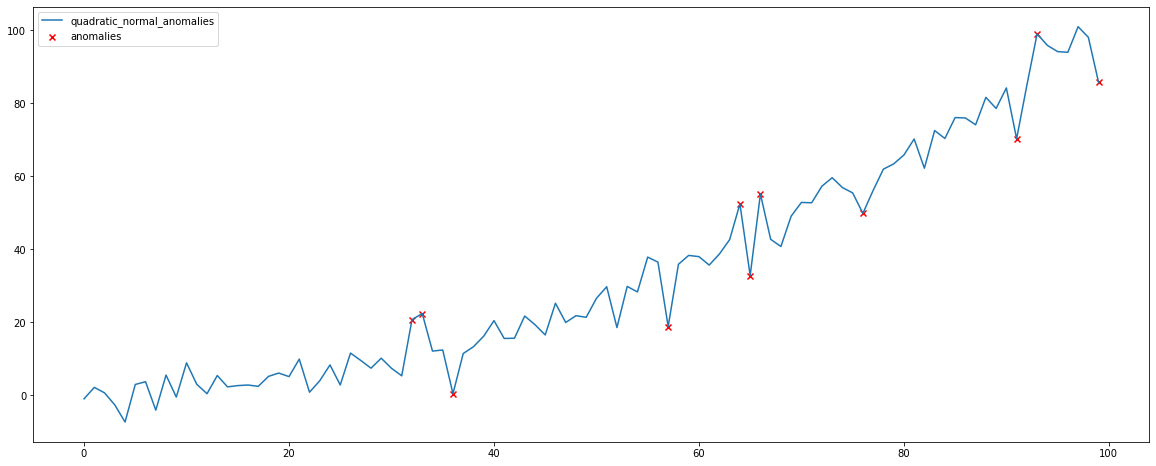

In [1140]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.legend()
plt.show()

## Restoring values

In [1141]:
data["quadratic_normal_anomalies_fix"] = fix_anomalies(data["quadratic_normal_anomalies"], anomaly_index)

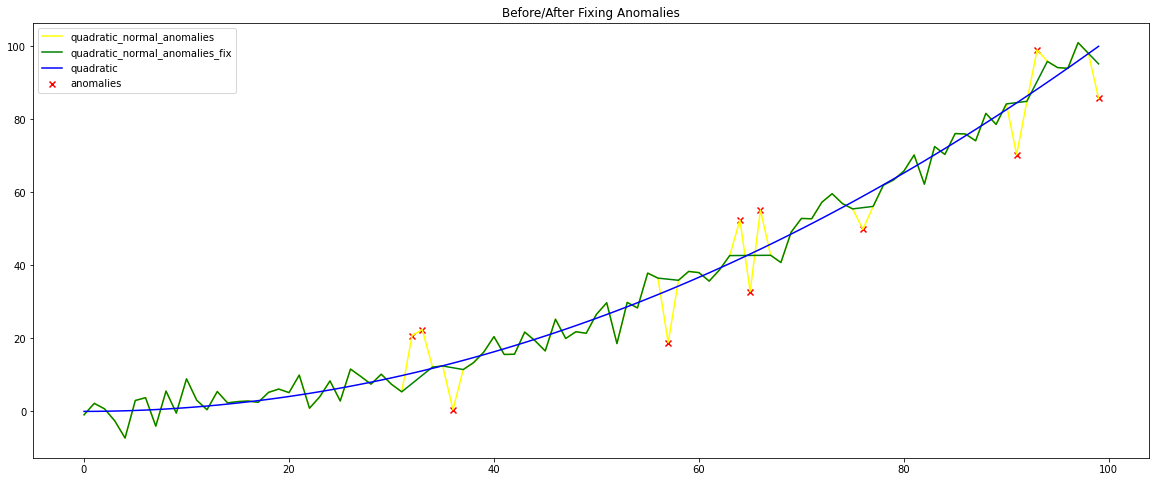

In [1142]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="yellow")
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.title("Before/After Fixing Anomalies")
plt.legend()
plt.show()

## Finding good values for Alpha-Beta filter

In [1143]:
# suppose that no filter is needed
benchmark = mse(data["quadratic"], data["quadratic_normal_anomalies_fix"])
best_alpha = 1
best_beta = 1
# gridsearch (not effective, but good enough)
for alpha in range(1, 10):
    for beta in range(1, 10):
        result = alpha_beta(data["quadratic_normal_anomalies_fix"], init_x=0, init_x_der=0, alpha=alpha/10, beta=beta/10)
        if mse(data["quadratic"], result["estimation"]) < benchmark:
            benchmark = mse(data["quadratic"], hist["estimation"])
            best_alpha = alpha / 10
            best_beta = beta / 10

print("MSE:", benchmark)
print("Alpha:", best_alpha)
print("Beta:", best_beta)

MSE: 3.081432847760335
Alpha: 0.3
Beta: 0.1


## Alpha Beta Filter

Mean Square Error
Before: 9.710194968979094
After: 3.081432847760335


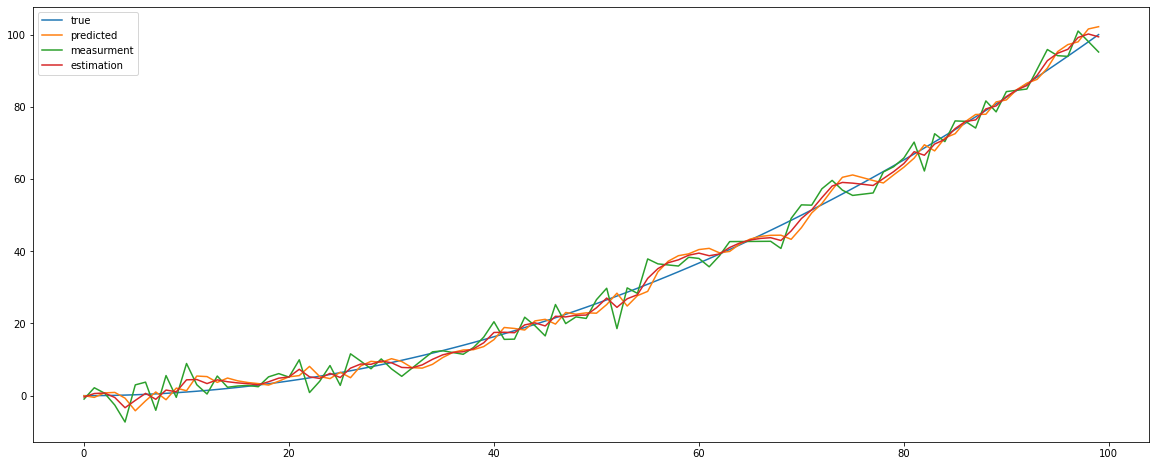

In [1144]:
# filter
hist = alpha_beta(data["quadratic_normal_anomalies_fix"], init_x=0, init_x_der=0, alpha=0.4, beta=0.1)
# save
data["quadratic_normal_anomalies_fix_ab"] = hist["estimation"].copy()
# print
print("Mean Square Error")
print("Before:", mse(data["quadratic"], data["quadratic_normal_anomalies_fix"]))
print("After:", mse(data["quadratic"], hist["estimation"]))
# plot
plt.plot(data["quadratic"], label="true")
plt.plot(hist["prediction"], label="predicted")
plt.plot(hist["measurment"], label="measurment")
plt.plot(hist["estimation"], label="estimation")
plt.legend()
plt.show()

## Finding good polynomial power for LSM smoothing

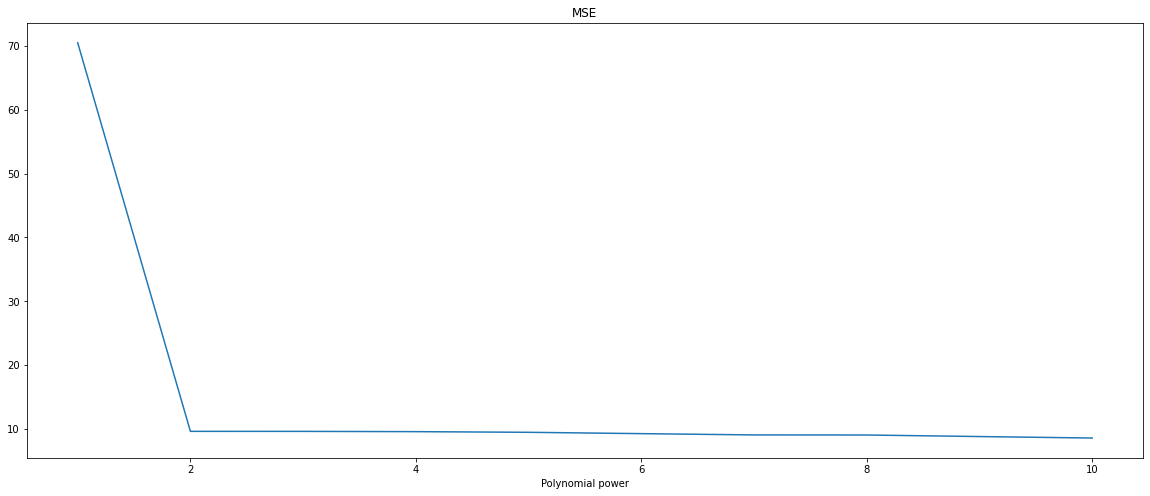

In [1145]:
errs = []
pow_range = range(1, PARAM_max_test_pow)
for power in pow_range:
    errs.append(mse(data["quadratic_normal_anomalies_fix"], lsm(data["quadratic_normal_anomalies_fix"], power)))
plt.title("MSE")
plt.xlabel("Polynomial power")
plt.plot(pow_range, errs)
plt.show()

In [1146]:
PARAM_best_pow = 2

## Using LSM on Data without Anomalies

In [1147]:
data["quadratic_normal_anomalies_fix_lsm"] = lsm(data["quadratic_normal_anomalies_fix"], PARAM_best_pow)

## Data Stats

In [1148]:
describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies,quadratic_normal_anomalies_fix,quadratic_normal_anomalies_fix_ab,quadratic_normal_anomalies_fix_lsm
count,100.000,100.000,100.000,100.000,100.000,100.000
mean,0.000,0.328,0.090,0.209,0.130,0.209
std,0.000,3.000,4.973,3.125,1.759,0.202
min,0.000,-7.460,-14.291,-9.012,-4.198,-0.015
25%,0.000,-1.637,-2.002,-1.690,-1.174,0.027
50%,0.000,0.365,0.454,0.338,0.253,0.153
75%,0.000,2.393,2.652,2.286,1.127,0.360
max,0.000,7.894,11.317,7.894,3.684,0.676
var,0.000,9.000,24.729,9.764,3.096,0.041


## Plot

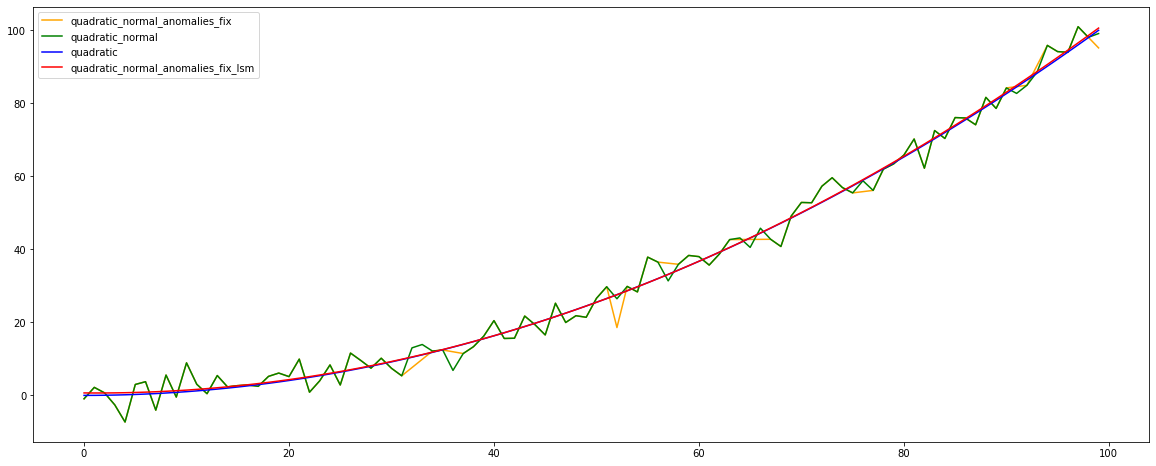

In [1149]:
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="orange")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.plot(data["quadratic_normal_anomalies_fix_lsm"], label="quadratic_normal_anomalies_fix_lsm", c="red")
plt.legend()
plt.show()

## Hist

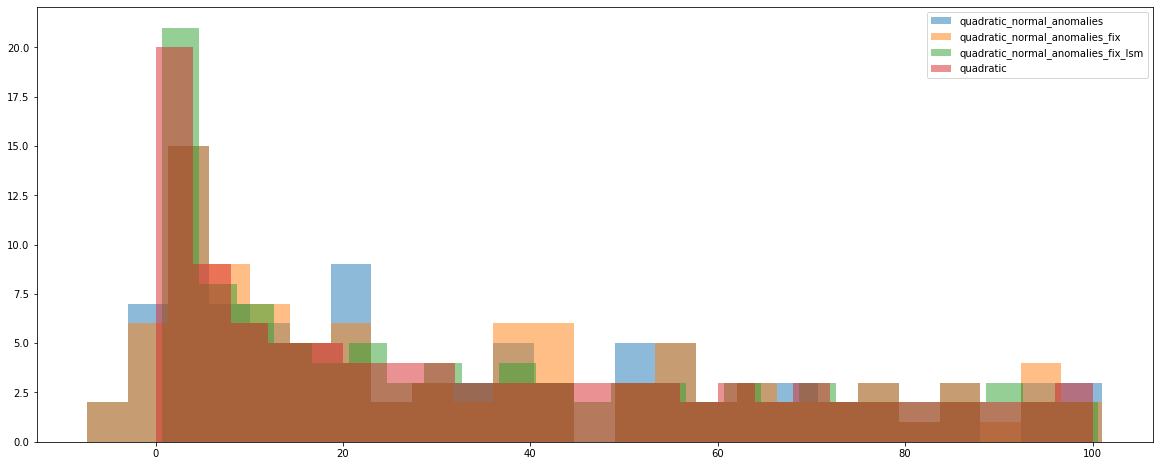

In [1150]:
plt.hist(data["quadratic_normal_anomalies"], bins=25, alpha=0.5, label="quadratic_normal_anomalies")
plt.hist(data["quadratic_normal_anomalies_fix"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix")
plt.hist(data["quadratic_normal_anomalies_fix_lsm"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix_lsm")
plt.hist(data["quadratic"], bins=25, alpha=0.5, label="quadratic")
plt.legend()
plt.show()